# DCA Ingest - Gantenbein - Gramzio Kohler Server
Dieses Notebook dient dem Einlesen, analysieren und exportieren von Daten des Digitalen Konstruktionsarchivs
Im ersten Schritt werden die Daten eines Verzeichnisses mithilfe von DROID analysiert.
Anschliessend können die Daten individuell analysiert werden.
Im letzten Schritt wird diese Analyse in RDF form festgehalten und zusammen mit den Metadaten des digitalen Materials exportiert.

## Imports und Setup

In [4]:
%pip install pandas matplotlib pywaffle seaborn rdflib ipywidgets pyshacl
import os
import subprocess
import sys
import pandas as pd
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Konfiguration

Hier werden alle Pfade und Parameter definiert.

In [5]:
# Pfad zum Datenset definieren
project_path = "WeingutGantenbein"
# Datenset (zu analysiernder Ordner) definieren
dataset_to_analyze = "gramazio-kohler-archiv-server"

# Dynamisches Home-Verzeichnis
home_dir = os.path.expanduser("~")
base_path = os.path.join(home_dir, "work")

# Pfade
droid_script_path = os.path.join(base_path, "27_DCA_Ingest/src/droid-binary-6.7.0-bin/droid.sh")
folder_to_analyze = os.path.join(base_path, f"dcaonnextcloud-500gb/DigitalMaterialCopies/{project_path}/{dataset_to_analyze}")
output_folder = os.path.join(base_path, f"dcaonnextcloud-500gb/dca-metadataraw/{project_path}/{dataset_to_analyze}_results")
output_csv_path = os.path.join(output_folder, f"{dataset_to_analyze}_DROIDresults.csv")

# Pfad zu src/ hinzufügen, um lokale Module zu importieren
src_path = os.path.join(base_path, "27_DCA_Ingest/src")
if src_path not in sys.path:
    sys.path.append(src_path)

print(f"Analyzing folder: {folder_to_analyze}")
print(f"Output will be saved to: {output_csv_path}")

Analyzing folder: /home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server
Output will be saved to: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/gramazio-kohler-archiv-server_DROIDresults.csv


## DROID-Analyse ausführen

Führt die DROID-Analyse auf dem konfigurierten Ordner aus.

In [3]:
try:
    # Output-Ordner erstellen (falls nicht vorhanden)
    os.makedirs(output_folder, exist_ok=True)

    print(f"Analyzing folder: {folder_to_analyze}")
    print(f"Output will be saved to: {output_csv_path}")

    # DROID-Skript ausführen mit "best match only"
    result = subprocess.run(
        [
            droid_script_path,
            "-R", folder_to_analyze,
            "-o", output_csv_path,
            "-Pr", "profile.generateHash=true",
            "-ff", "file_name not startswith ~$"
        ],
        check=True,
        capture_output=True,
        text=True
    )

    print("DROID output:", result.stdout)
    print(f"Analysis complete. The result is saved in {output_csv_path}.")

except subprocess.CalledProcessError as e:
    print(f"An error occurred while running DROID: {e}")
    print("DROID error output:", e.stderr)

except PermissionError as e:
    print(f"Permission error: {e}")
    print("Bitte prüfe, ob du Schreibrechte für den Zielordner hast.")

except FileNotFoundError as e:
    print(f"Datei oder Verzeichnis nicht gefunden: {e}")
    print("Bitte prüfe, ob alle Pfade korrekt sind und existieren.")

Analyzing folder: /home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server
Output will be saved to: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/gramazio-kohler-archiv-server_DROIDresults.csv
DROID output: 2026-02-27T09:57:08,702  INFO [main] DroidCommandLine:225 - Starting DROID.
2026-02-27T09:57:09,612  INFO [main] ProfileManagerImpl:129 - Creating profile: 1772186229612
2026-02-27T09:57:09,633  INFO [main] ProfileInstance:365 - Attempting state change [INITIALISING] to [VIRGIN]
2026-02-27T09:57:12,913  INFO [main] ProfileDiskAction:87 - Saving profile [/home/renku/.droid6/profiles/1772186229612/db] to [/home/renku/.droid6/profile_templates/schema 6.7.0/profile.template]
2026-02-27T09:57:17,039  INFO [main] ProfileDiskAction:87 - Saving profile [/home/renku/.droid6/profiles/1772186229612/db] to [/home/renku/.droid6/profile_templates/schema 6.7.0/profile.114.template]
20

## Analyse der DROID-Ergebnisse

Die folgenden Zellen führen verschiedene Analysen auf den DROID-Ergebnissen durch.

In [11]:
# Pfade für die Analyse konfigurieren
# CSV_PATH: Pfad zur DROID-Ausgabe-CSV
if "output_csv_path" in locals():
    CSV_PATH = output_csv_path
else:
    # Fallback, falls output_csv_path nicht definiert wurde
    CSV_PATH = os.path.join(base_path, f"dcaonnextcloud-500gb/dca-metadataraw/Semiramis/{dataset_to_analyze}_results/analysis_result.csv")

# OUTPUT_DIR: Verzeichnis für Analyse-Ausgaben
OUTPUT_DIR = os.path.join(output_folder, "res")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"CSV-Datei für Analyse: {CSV_PATH}")
print(f"Ausgabeverzeichnis für Plots: {OUTPUT_DIR}")

CSV-Datei für Analyse: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/gramazio-kohler-archiv-server_DROIDresults.csv
Ausgabeverzeichnis für Plots: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/res


In [1]:
# Analyse: Anzahl der Dateien pro Format
try:
    from analyse_formats import analyse_formats
    analyse_formats(CSV_PATH, OUTPUT_DIR, show_plot=False)
except ImportError:
    print("Hinweis: analyse_formats Modul nicht gefunden. Überspringe diese Analyse.")
except FileNotFoundError as e:
    print(f"Datei nicht gefunden: {e}")
except Exception as e:
    print(f"Fehler bei analyse_formats: {e}")

Hinweis: analyse_formats Modul nicht gefunden. Überspringe diese Analyse.


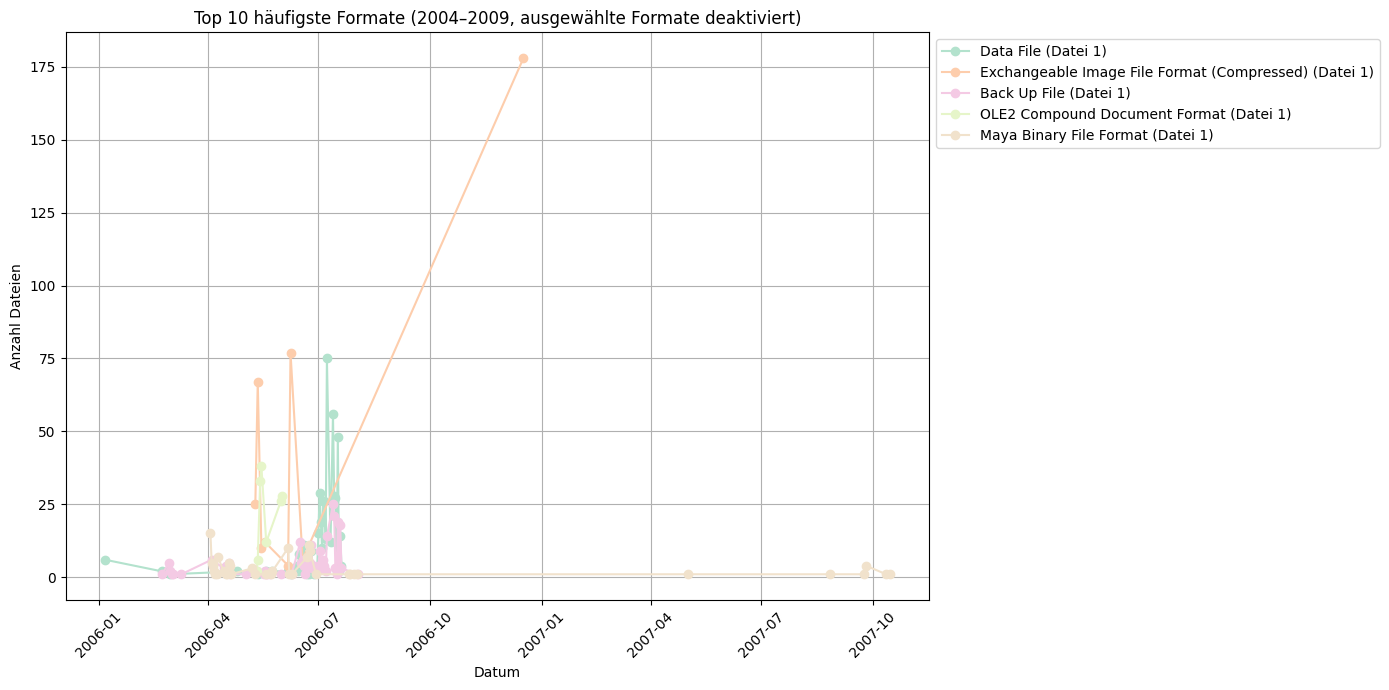

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def analyse_sel_formats(csv_path, output_dir=None, show_plot=True):

    # Konfigurierbare Ausschlussliste
    deaktivierte_formate = {
        "Windows Bitmap",
        "JPEG File Interchange Format",
        "Tagged Image File Format",
        "ZIP Format",
        "Acrobat PDF 1.3 - Portable Document Format",
        "Acrobat PDF 1.4 - Portable Document Format",
        "Acrobat PDF 1.6 - Portable Document Format"
    }
    
    # Start- und Enddatum
    startjahr = 2006
    endjahr = 2007

    # CSV-Dateien einlesen
    df = pd.read_csv(csv_path)

    # Spalte 'LAST_MODIFIED' in datetime umwandeln
    df['LAST_MODIFIED'] = pd.to_datetime(df['LAST_MODIFIED'], errors='coerce')


    # Zeitraum filtern: nur Daten von 2004 bis 2009
    df = df[(df['LAST_MODIFIED'].dt.year >= startjahr) & (df['LAST_MODIFIED'].dt.year <= endjahr)]

    # Optional: Formate ausschließen
    df = df[~df['FORMAT_NAME'].isin(deaktivierte_formate)]

    # Die 5 häufigsten Formate in beiden Dateien ermitteln
    top_formats = df['FORMAT_NAME'].value_counts().nlargest(5).index

    # Plot vorbereiten
    plt.figure(figsize=(14, 7))

    # Farben für Datei 1 (Blau-Schattierung)
    #colors1 = plt.cm.Blues_r(range(50, 50 + 20 * len(top_formats1), 20))
    pastel2 = plt.get_cmap("Pastel2")

    # Farben für Datei 1
    colors1 = [pastel2(i / len(top_formats)) for i in range(len(top_formats))]


    # Plot für Datei 1
    for i, format_name in enumerate(top_formats):
        format_df = df[df['FORMAT_NAME'] == format_name].copy()
        format_df = format_df.sort_values('LAST_MODIFIED')
        time_series = format_df['LAST_MODIFIED'].dt.date.value_counts().sort_index()
        plt.plot(time_series.index, time_series.values, marker='o', linestyle='-', label=f"{format_name} (Datei 1)", color=colors1[i])



    # Diagramm formatieren
    plt.title("Top 10 häufigste Formate (2004–2009, ausgewählte Formate deaktiviert)")
    plt.xlabel("Datum")
    plt.ylabel("Anzahl Dateien")
    plt.xticks(rotation=45)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("../res/vergleich_top10_formats_bereinigt.png")
    plt.show()
try:
    analyse_sel_formats(CSV_PATH, OUTPUT_DIR, show_plot=False)
except ImportError:
    print("Hinweis: analyse_formats Modul nicht gefunden. Überspringe diese Analyse.")
except FileNotFoundError as e:
    print(f"Datei nicht gefunden: {e}")
except Exception as e:
    print(f"Fehler bei analyse_formats: {e}")

Analysiere zeitliche Verteilung von: JPEG File Interchange Format
Plot gespeichert unter: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/res/jpeg file interchange format_time_series.png


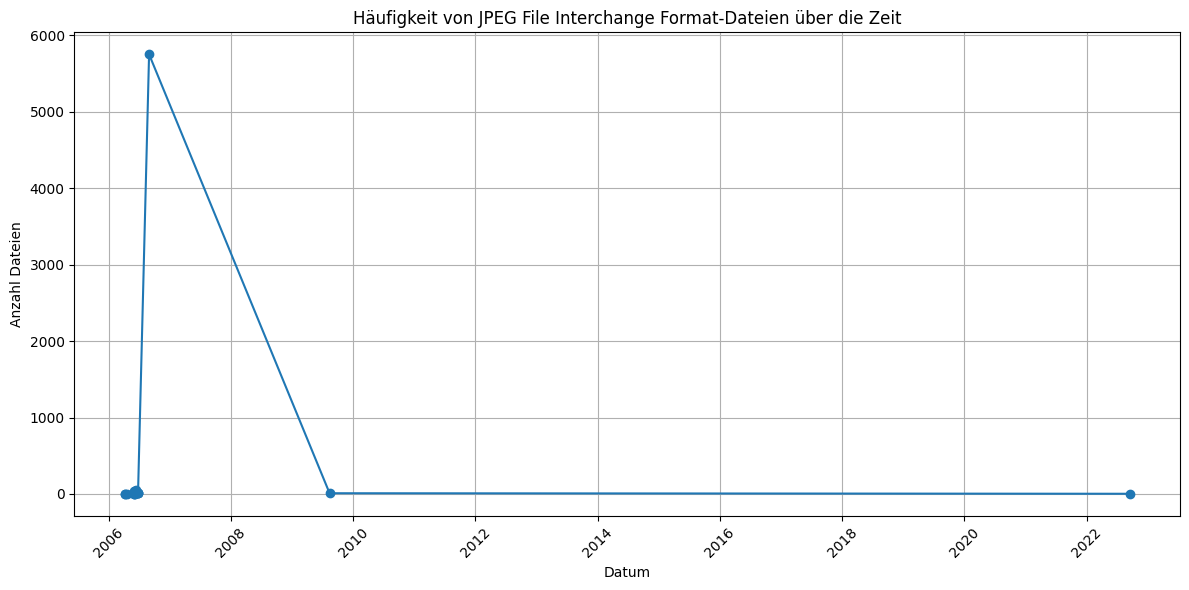

In [8]:
# Analyse: Zeitliche Verteilung eines spezifischen Formats
# Beispiel: Analysiere das häufigste Format über die Zeit
try:
    from analyse_format_last_modified import analyse_format_last_modified
    
    # Ermittle das häufigste Format
    if os.path.exists(CSV_PATH):
        df = pd.read_csv(CSV_PATH)
        most_common_format = df["FORMAT_NAME"].value_counts().index[0]
        print(f"Analysiere zeitliche Verteilung von: {most_common_format}")
        analyse_format_last_modified(CSV_PATH, most_common_format, OUTPUT_DIR, show_plot=False)
    else:
        print(f"CSV-Datei nicht gefunden: {CSV_PATH}")
except ImportError:
    print("Hinweis: analyse_format_over_time Modul nicht gefunden. Überspringe diese Analyse.")
except Exception as e:
    print(f"Fehler bei analyse_format_over_time: {e}")

Heatmap für Zeitraum: 1999-2025
Plot gespeichert unter: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/res/heatmap_top10_formats_by_month_1999_2025.png


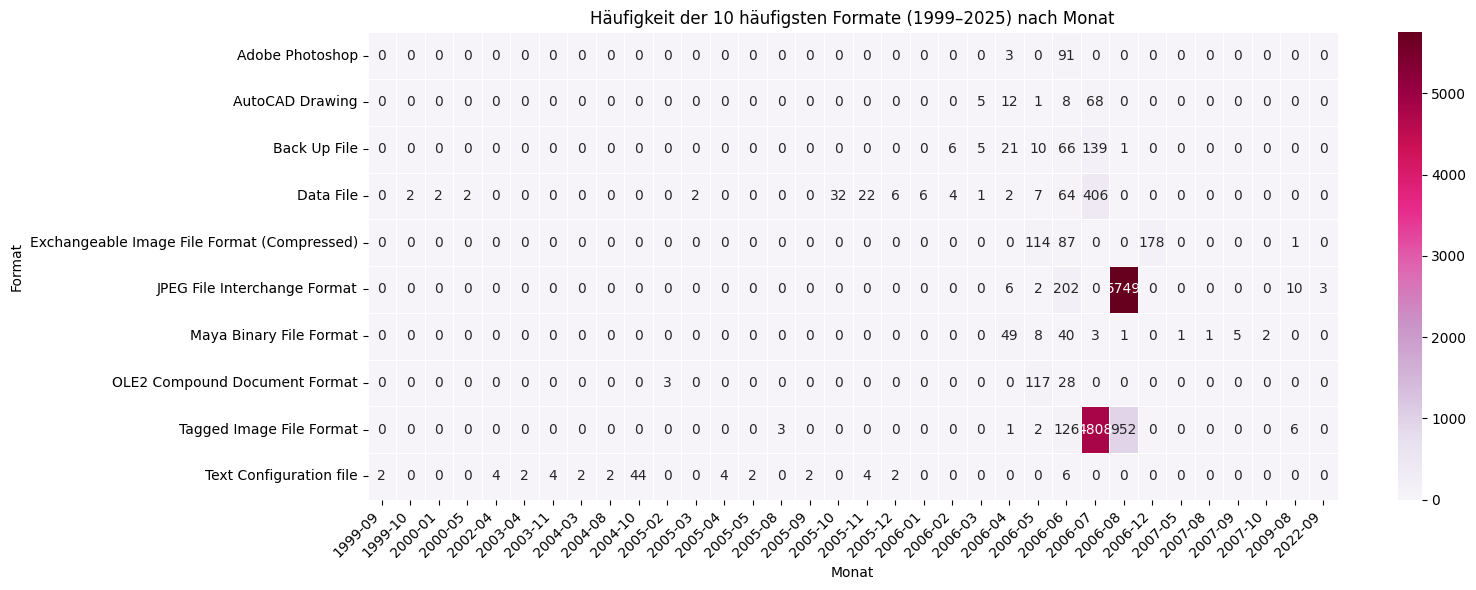

In [9]:
# Analyse: Heatmap der häufigsten Formate nach Monat
try:
    from analyse_format_heatmap import generate_format_heatmap
    
    # Ermittle den Zeitraum aus den Daten
    if os.path.exists(CSV_PATH):
        df = pd.read_csv(CSV_PATH)
        df["LAST_MODIFIED"] = pd.to_datetime(df["LAST_MODIFIED"], errors="coerce")
        df_clean = df.dropna(subset=["LAST_MODIFIED"])
        
        if len(df_clean) > 0:
            start_year = df_clean["LAST_MODIFIED"].dt.year.min()
            end_year = df_clean["LAST_MODIFIED"].dt.year.max()
            print(f"Heatmap für Zeitraum: {start_year}-{end_year}")
            generate_format_heatmap(CSV_PATH, OUTPUT_DIR, start_year, end_year, top_n=10, show_plot=False)
        else:
            print("Keine gültigen Datumsangaben in den Daten gefunden.")
    else:
        print(f"CSV-Datei nicht gefunden: {CSV_PATH}")
except ImportError as e:
    print(f"Hinweis: Modul nicht gefunden ({e}). Überspringe Heatmap.")
    print("Installieren Sie seaborn falls benötigt: pip install seaborn")
except Exception as e:
    print(f"Fehler bei generate_format_heatmap: {e}")

Waffle-Chart für Zeitraum: 2006-2007
Plot gespeichert unter: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/res/waffle_files_per_month_2006_2007.png


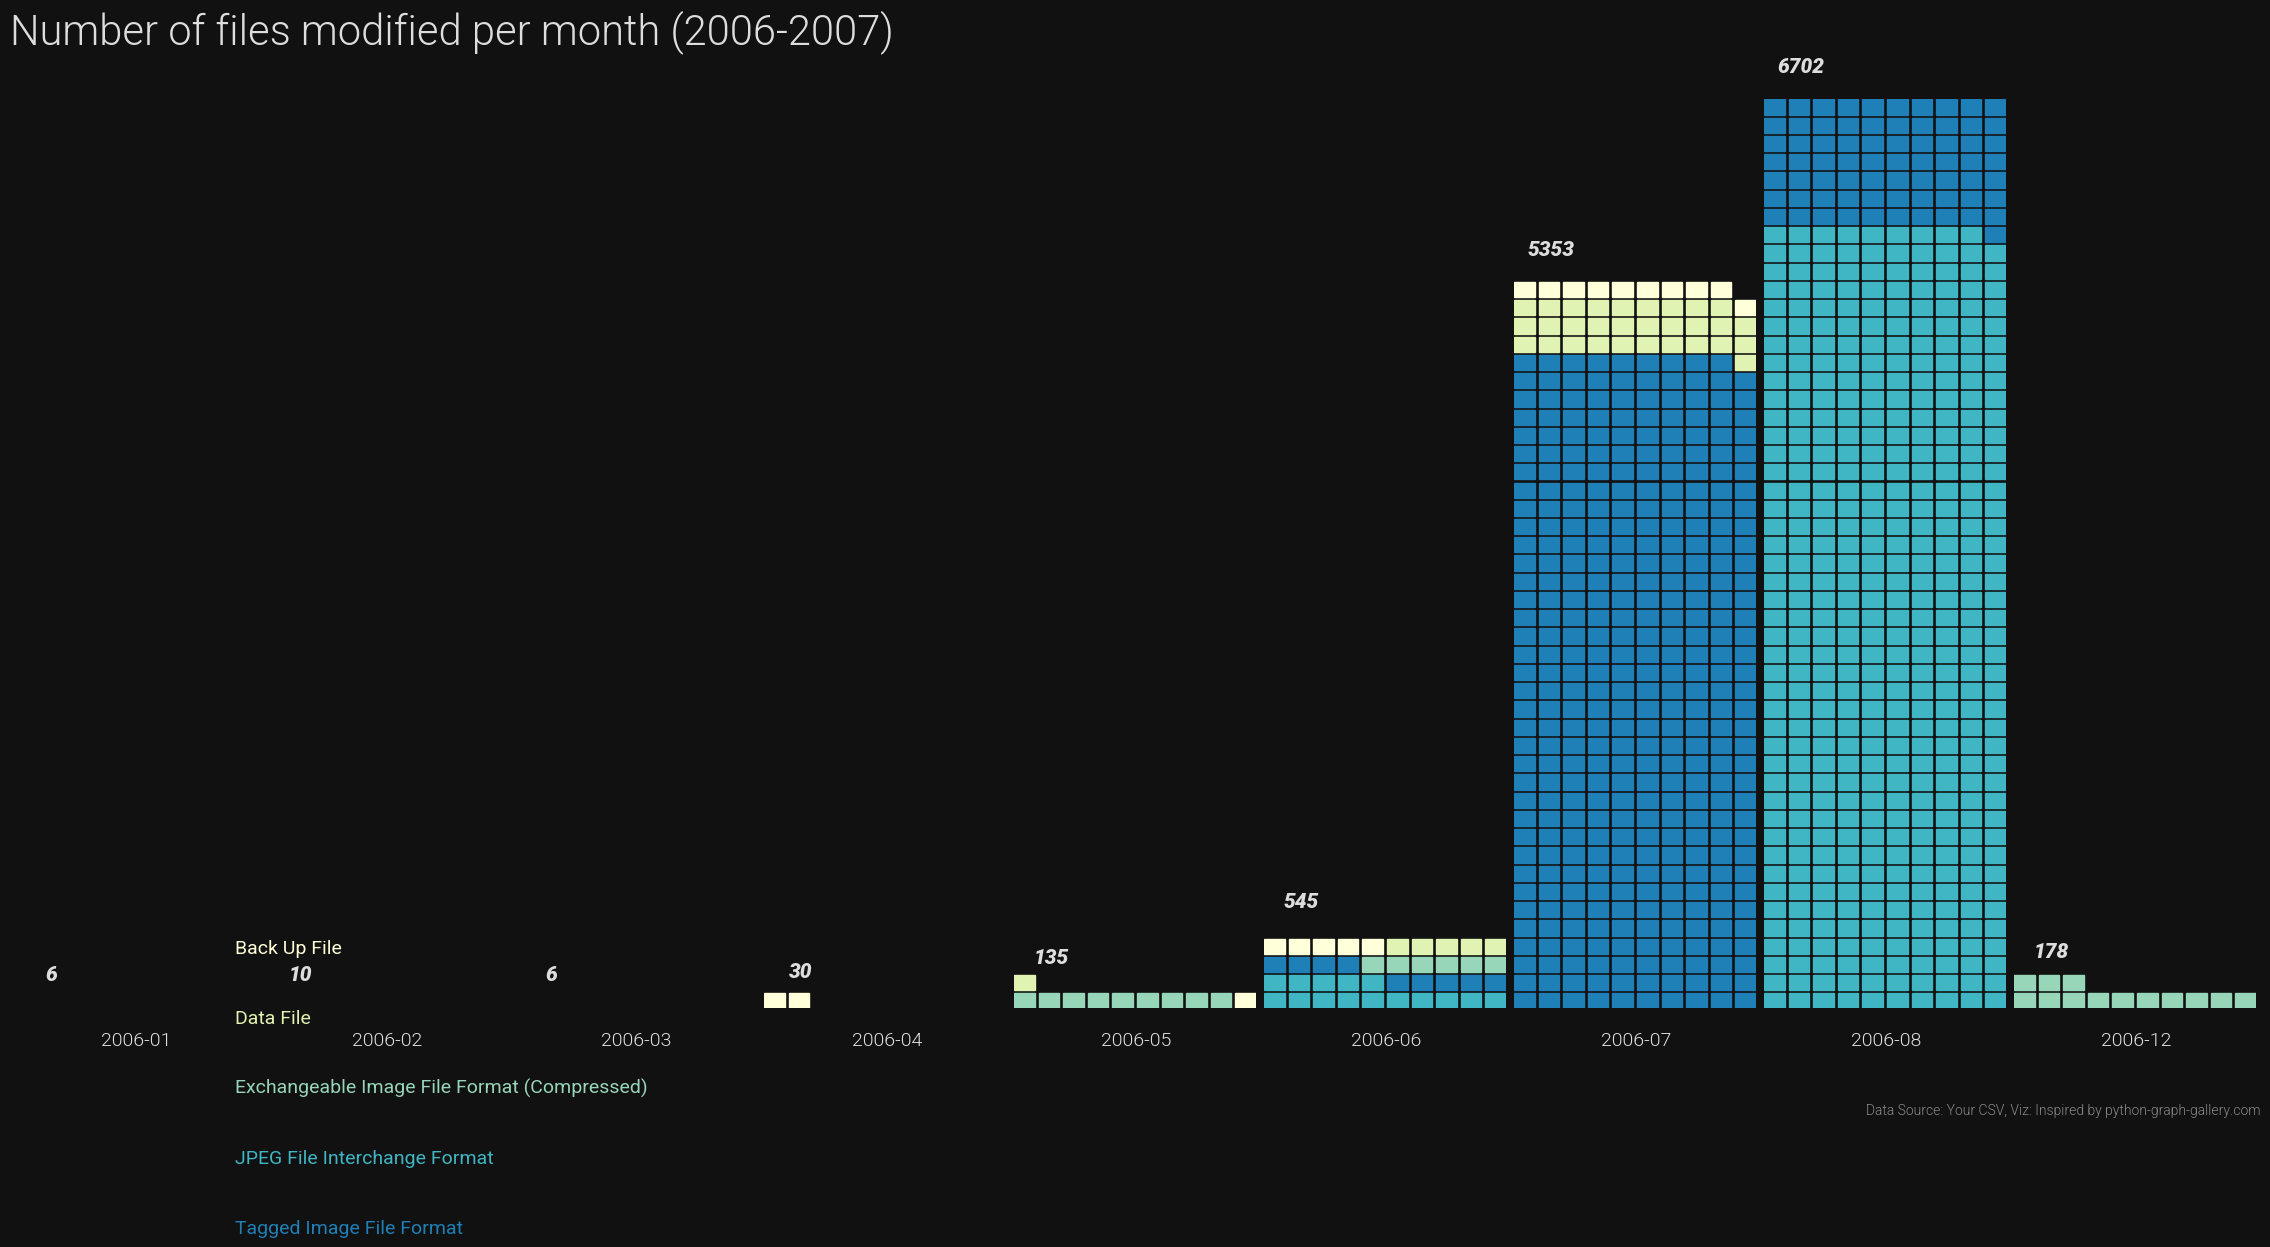

In [10]:
# Analyse: Waffle-Chart für monatliche Dateihäufigkeit

try:
    from generate_waffle import generate_waffle_chart
    
    # Ermittle den Zeitraum aus den Daten
    if os.path.exists(CSV_PATH):
        df = pd.read_csv(CSV_PATH)
        df["LAST_MODIFIED"] = pd.to_datetime(df["LAST_MODIFIED"], errors="coerce")
        df_clean = df.dropna(subset=["LAST_MODIFIED"])
        
        if len(df_clean) > 0:
            start_year = 2006
            end_year = 2007
            print(f"Waffle-Chart für Zeitraum: {start_year}-{end_year}")
            
            generate_waffle_chart(
                csv_path=CSV_PATH,
                output_dir=OUTPUT_DIR,
                start_year=start_year,
                end_year=end_year,
                top_n=5,
                show_plot=False,
                date_col="LAST_MODIFIED"
            )

        else:
            print("Keine gültigen Datumsangaben in den Daten gefunden.")
    else:
        print(f"CSV-Datei nicht gefunden: {CSV_PATH}")
except ImportError as e:
    print(f"Hinweis: Modul nicht gefunden ({e}). Überspringe Waffle-Chart.")
    print("Installieren Sie pywaffle falls benötigt: pip install pywaffle")
except Exception as e:
    print(f"Fehler bei generate_waffle_chart: {e}")

## Droid to RDF

Setup

In [13]:
# =====================================================
# FIRST RUN IN RENKULAB: Install dependencies
# =====================================================
# !pip install rdflib pandas exifread pillow networkx

from pathlib import Path
import pandas as pd
import json, subprocess, hashlib, sys, math, re
from datetime import datetime
from typing import Optional, Dict, List, Set, Union
import warnings
warnings.filterwarnings('ignore')

# RDF Core Libraries
from rdflib import Graph, Namespace, URIRef, BNode, Literal
from rdflib.namespace import RDF, RDFS, XSD, DCTERMS
from rdflib.plugins.serializers.turtle import TurtleSerializer

# Optional: Network analysis for provenance graphs
try:
    import networkx as nx
    NX_AVAILABLE = True
except ImportError:
    print("⚠️  NetworkX not available - provenance graphs disabled")
    NX_AVAILABLE = False

print("✅ All dependencies loaded successfully")
print(f"📅 DCA Pipeline started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔧 Python {sys.version_info.major}.{sys.version_info.minor}")
print(f"📚 RDFLib version: {getattr(Graph(), 'version', 'unknown')}")

✅ All dependencies loaded successfully
📅 DCA Pipeline started: 2026-02-27 12:23:56
🔧 Python 3.10
📚 RDFLib version: unknown


Digital Construction Archive (DCA) Ontology Setup

In [14]:
# =====================================================
# DCA ONTOLOGY NAMESPACES - ETH Zürich Standard
# =====================================================

# Core DCA Namespaces
DCA      = Namespace("http://dca.ethz.ch/ontology#")     # DCA Classes & Properties
DCA_ID   = Namespace("http://dca.ethz.ch/id/")          # Individual Resources
DCA_TECH = Namespace("http://dca.ethz.ch/tech#")        # Technical Properties

# International Standards
PREMIS   = Namespace("http://www.loc.gov/premis/rdf/v3/")  # Digital Preservation Metadata
RICO     = Namespace("https://www.ica.org/standards/RiC/ontology#")  # Records in Contexts
# DCTERMS already imported from rdflib.namespace

# Utility
OWL      = Namespace("http://www.w3.org/2002/07/owl#")
XSDNS    = XSD  # Shorthand

# =====================================================
# DCA FILE TYPE DEFINITIONS
# =====================================================

# Image file extensions (construction documentation)
IMG_EXTENSIONS = {
    "jpg", "jpeg", "tif", "tiff", "png", "gif", "bmp", "webp",
    # RAW formats (professional photography)
    "dng", "cr2", "cr3", "nef", "arw", "orf", "rw2"
}

# Adobe Creative Suite formats
ADOBE_EXTENSIONS = {
    "psd", "psb", "ai", "indd", "idml", "eps",
    "pdf"  # Often contains rich Adobe metadata
}

# CAD & Engineering formats
CAD_EXTENSIONS = {
    "dwg", "dxf", "step", "stp", "iges", "igs", 
    "ifc", "3dm", "skp"  # BIM/Architecture specific
}

# Combined target extensions for metadata enrichment
TARGET_EXTENSIONS = IMG_EXTENSIONS | ADOBE_EXTENSIONS | CAD_EXTENSIONS

print(f"🏗️  DCA Ontology initialized")
print(f"📁 Target file types: {len(TARGET_EXTENSIONS)} extensions")
print(f"📸 Image types: {len(IMG_EXTENSIONS)}")
print(f"🎨 Adobe types: {len(ADOBE_EXTENSIONS)}")
print(f"📐 CAD types: {len(CAD_EXTENSIONS)}")

🏗️  DCA Ontology initialized
📁 Target file types: 31 extensions
📸 Image types: 15
🎨 Adobe types: 7
📐 CAD types: 9


DCA ID Generation - MD5-Based Consistent Identifiers

In [15]:
# =====================================================
# DCA ID GENERATION - MD5-BASED SYSTEM
# =====================================================

# Base URI for all DCA identifiers
DCA_ID_BASE = "http://dca.ethz.ch/id/"

def dca_file_uri_from_md5(md5_hex: Optional[str]) -> Optional[URIRef]:
    """
    Creates dca-id:file_<md5[:16]> from MD5 hex string (DROID format).
    
    Args:
        md5_hex: MD5 hash as hex string (32 chars)
        
    Returns:
        URIRef or None if invalid input
        
    Example:
        md5 = "a1b2c3d4e5f6789012345678901234ab"
        → dca-id:file_a1b2c3d4e5f67890
    """
    if not md5_hex or not isinstance(md5_hex, str):
        return None
    
    # Clean and validate
    md5_clean = md5_hex.strip().lower()
    if len(md5_clean) < 16 or not re.match(r'^[a-f0-9]+$', md5_clean):
        return None
    
    # Use first 16 characters for consistent short IDs
    short_id = md5_clean[:16]
    return URIRef(DCA_ID_BASE + f"file_{short_id}")

def dca_file_uri_from_path_fallback(file_path: str) -> URIRef:
    """
    Fallback ID generation from file path (when MD5 not available).
    
    WARNING: Only use this if DROID MD5 is unavailable!
    Path-based IDs are less stable than content-based MD5.
    """
    path_normalized = str(Path(file_path)).replace('\\', '/')  # Normalize separators
    path_hash = hashlib.sha256(path_normalized.encode('utf-8')).hexdigest()[:16]
    return URIRef(DCA_ID_BASE + f"file_{path_hash}")

def dca_project_uri(project_name: str) -> URIRef:
    """
    Generate project URI following DCA conventions.
    
    Example: "WeingutGantenbein" → dca-id:project_WeingutGantenbein
    """
    # Sanitize project name for URI use
    sanitized = re.sub(r'[^a-zA-Z0-9_-]', '_', project_name)
    return URIRef(DCA_ID_BASE + f"project_{sanitized}")

def dca_activity_uri(activity_name: str) -> URIRef:
    """
    Generate activity URI for provenance tracking.
    
    Example: "ArchivingGantenbein2026" → dca-id:ArchivingGantenbein2026
    """
    sanitized = re.sub(r'[^a-zA-Z0-9_-]', '_', activity_name)
    return URIRef(DCA_ID_BASE + sanitized)

# Test the ID generation
test_md5 = "a1b2c3d4e5f6789012345678901234ab"
test_uri = dca_file_uri_from_md5(test_md5)
print(f"✅ ID Generation Functions Ready")
print(f"🧪 Test MD5: {test_md5}")
print(f"🆔 Generated URI: {test_uri}")
print(f"📏 ID Length: {len(str(test_uri).split('_')[1])} characters")

✅ ID Generation Functions Ready
🧪 Test MD5: a1b2c3d4e5f6789012345678901234ab
🆔 Generated URI: http://dca.ethz.ch/id/file_a1b2c3d4e5f67890
📏 ID Length: 16 characters


 RenkuLab Pfad-Konfiguration

In [17]:
# =====================================================
# RENKULAB PATH CONFIGURATION
# =====================================================
# TODO: Adjust these paths to match your RenkuLab project structure!

# Input: DROID CSV results
DROID_CSV_PATH = Path("/home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/gramazio-kohler-archiv-server_DROIDresults.csv")
# Alternative if in project subdirectory:
# DROID_CSV_PATH = Path("./data/droid_results.csv")

# Input: Base directory containing the actual files (for ExifTool)
FILES_BASE_DIR = Path("/home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein")
# Alternative:
# FILES_BASE_DIR = Path("./data/files/")

# Output: Generated RDF file
OUTPUT_RDF_PATH = Path("/home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/dca_catalog_generated.ttl")

# Optional: Existing RDF to merge with
EXISTING_RDF_PATH = Path("/home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/dca_catalog_generated.ttl")  # Set to None if not available

# ExifTool configuration
EXIFTOOL_COMMAND = "exiftool"  # Adjust if installed in different location
# For custom installation: 
# EXIFTOOL_COMMAND = "/home/renku/work/tools/exiftool/exiftool"

# Project metadata
PROJECT_NAME = "WeingutGantenbein"  # Will become dca-id:project_WeingutGantenbein
ACTIVITY_NAME = "ArchivingGantenbein2026"  # Provenance activity

# Validation
print("📂 RenkuLab Path Configuration:")
print(f"📊 DROID CSV: {DROID_CSV_PATH}")
print(f"📁 Files Base: {FILES_BASE_DIR}")
print(f"💾 Output RDF: {OUTPUT_RDF_PATH}")
print(f"🏗️  Project: {PROJECT_NAME}")

# Check critical paths
if DROID_CSV_PATH.exists():
    print(f"✅ DROID CSV found: {DROID_CSV_PATH.stat().st_size / 1024 / 1024:.1f} MB")
else:
    print(f"❌ DROID CSV not found: {DROID_CSV_PATH}")
    print("   → Please update DROID_CSV_PATH to correct location")

if FILES_BASE_DIR.exists():
    print(f"✅ Files base directory found")
else:
    print(f"❌ Files base directory not found: {FILES_BASE_DIR}")
    print("   → ExifTool operations will be skipped")

📂 RenkuLab Path Configuration:
📊 DROID CSV: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/gramazio-kohler-archiv-server_DROIDresults.csv
📁 Files Base: /home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein
💾 Output RDF: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/WeingutGantenbein/gramazio-kohler-archiv-server_results/dca_catalog_generated.ttl
🏗️  Project: WeingutGantenbein
✅ DROID CSV found: 9.7 MB
✅ Files base directory found


DROID CSV Laden & Analysieren

In [18]:
# =====================================================
# LOAD AND ANALYZE DROID CSV DATA
# =====================================================

def load_droid_csv(csv_path: Path) -> pd.DataFrame:
    """
    Load DROID CSV with proper encoding and error handling.
    
    Returns DataFrame with standardized column names.
    """
    try:
        # Try UTF-8 first
        df = pd.read_csv(csv_path, encoding='utf-8')
    except UnicodeDecodeError:
        try:
            # Fallback to latin-1
            df = pd.read_csv(csv_path, encoding='latin-1')
            print("⚠️  Used latin-1 encoding for CSV")
        except Exception as e:
            print(f"❌ Failed to read CSV: {e}")
            return pd.DataFrame()
    
    print(f"📊 DROID CSV loaded: {len(df):,} records")
    print(f"📋 Columns: {list(df.columns)}")
    
    return df

def analyze_droid_data(df: pd.DataFrame) -> Dict[str, any]:
    """
    Analyze DROID data for DCA processing insights.
    """
    if df.empty:
        return {}
    
    analysis = {}
    
    # File type analysis
    if 'EXT' in df.columns:
        ext_counts = df['EXT'].value_counts()
        analysis['extensions'] = ext_counts.head(20).to_dict()
        
        # Target extensions analysis
        df['ext_lower'] = df['EXT'].str.lower() if 'EXT' in df.columns else ''
        target_mask = df['ext_lower'].isin(TARGET_EXTENSIONS)
        analysis['target_files'] = target_mask.sum()
        analysis['total_files'] = len(df)
    
    # MD5 hash analysis
    md5_col = None
    for col in ['MD5_HASH', 'HASH', 'md5', 'MD5']:
        if col in df.columns:
            md5_col = col
            break
    
    if md5_col:
        analysis['md5_column'] = md5_col
        analysis['md5_available'] = df[md5_col].notna().sum()
    else:
        analysis['md5_column'] = None
        analysis['md5_available'] = 0
    
    return analysis

# Load the data
print("🔄 Loading DROID CSV data...")
droid_df = load_droid_csv(DROID_CSV_PATH)

if not droid_df.empty:
    analysis = analyze_droid_data(droid_df)
    
    print("\n📈 DROID Data Analysis:")
    print(f"📊 Total files: {analysis.get('total_files', 0):,}")
    print(f"🎯 Target files (img/adobe/cad): {analysis.get('target_files', 0):,}")
    print(f"#️⃣  MD5 hashes available: {analysis.get('md5_available', 0):,}")
    if analysis.get('md5_column'):
        print(f"🔑 MD5 column: '{analysis['md5_column']}'")
    
    if analysis.get('extensions'):
        print("\n📁 Top file extensions:")
        for ext, count in list(analysis['extensions'].items())[:10]:
            print(f"   .{ext}: {count:,} files")
else:
    print("❌ No DROID data available - check file path!")

🔄 Loading DROID CSV data...
📊 DROID CSV loaded: 14,875 records
📋 Columns: ['ID', 'PARENT_ID', 'URI', 'FILE_PATH', 'NAME', 'METHOD', 'STATUS', 'SIZE', 'TYPE', 'EXT', 'LAST_MODIFIED', 'EXTENSION_MISMATCH', 'HASH', 'FORMAT_COUNT', 'PUID', 'MIME_TYPE', 'FORMAT_NAME', 'FORMAT_VERSION']

📈 DROID Data Analysis:
📊 Total files: 14,875
🎯 Target files (img/adobe/cad): 12,590
#️⃣  MD5 hashes available: 14,575
🔑 MD5 column: 'HASH'

📁 Top file extensions:
   .jpg: 6,352 files
   .tif: 5,898 files
   .dat: 558 files
   .src: 272 files
   .bak: 257 files
   .mel: 113 files
   .mb: 109 files
   .psd: 94 files
   .dwg: 92 files
   .ini: 80 files


RDF Graph Initialisierung mit DCA Ontology

In [19]:
# =====================================================
# INITIALIZE RDF GRAPH WITH DCA ONTOLOGY
# =====================================================

def create_dca_graph() -> Graph:
    """
    Create RDF graph with DCA ontology structure and namespace bindings.
    """
    g = Graph()
    
    # Bind namespaces for clean Turtle output
    g.bind("dca", DCA)
    g.bind("dca-id", DCA_ID)
    g.bind("dca-tech", DCA_TECH)
    g.bind("premis", PREMIS)
    g.bind("rico", RICO)
    g.bind("dcterms", DCTERMS)
    g.bind("owl", OWL)
    g.bind("xsd", XSD)
    
    return g

def add_ontology_definitions(g: Graph):
    """
    Add DCA ontology class and property definitions.
    """
    # Ontology declaration
    ontology_uri = URIRef("http://dca.ethz.ch/ontology")
    g.add((ontology_uri, RDF.type, OWL.Ontology))
    g.add((ontology_uri, DCTERMS.created, Literal(datetime.now().strftime("%Y-%m-%d"), datatype=XSD.date)))
    g.add((ontology_uri, DCTERMS.creator, Literal("ETH Zurich - Digital Construction Archive Project")))
    g.add((ontology_uri, DCTERMS.description, 
           Literal("Standards-based ontology for digital construction archives using RiC-O, PREMIS, and Dublin Core with clean namespace separation and Nextcloud WebDAV integration", lang="en")))
    
    # DCA Classes
    g.add((DCA.ConstructionProject, RDF.type, OWL.Class))
    g.add((DCA.ConstructionProject, RDFS.label, Literal("Construction Project", lang="en")))
    g.add((DCA.ConstructionProject, RDFS.comment, 
           Literal("A construction or architectural project containing digital files", lang="en")))
    g.add((DCA.ConstructionProject, RDFS.subClassOf, RICO.RecordSet))
    
    g.add((DCA.ArchiveFile, RDF.type, OWL.Class))
    g.add((DCA.ArchiveFile, RDFS.label, Literal("Archive File", lang="en")))
    g.add((DCA.ArchiveFile, RDFS.comment, 
           Literal("A digital file within the construction archive", lang="en")))
    g.add((DCA.ArchiveFile, RDFS.subClassOf, PREMIS.Object))
    g.add((DCA.ArchiveFile, RDFS.subClassOf, RICO.Record))
    
    # DCA Properties
    g.add((DCA.belongsToProject, RDF.type, OWL.ObjectProperty))
    g.add((DCA.belongsToProject, RDFS.label, Literal("belongs to project", lang="en")))
    g.add((DCA.belongsToProject, RDFS.comment, 
           Literal("Indicates that a file belongs to a specific construction project", lang="en")))
    g.add((DCA.belongsToProject, RDFS.domain, DCA.ArchiveFile))
    g.add((DCA.belongsToProject, RDFS.range, DCA.ConstructionProject))
    
    # Technical properties
    g.add((DCA_TECH.sourcePath, RDF.type, OWL.DatatypeProperty))
    g.add((DCA_TECH.sourcePath, RDFS.label, Literal("source path", lang="en")))
    g.add((DCA_TECH.sourcePath, RDFS.comment, 
           Literal("DEPRECATED: Original filesystem path from DROID analysis. Use dcterms:identifier with Nextcloud WebDAV URL instead to avoid redundancy.", lang="en")))
    g.add((DCA_TECH.sourcePath, RDFS.domain, RICO.Record))
    g.add((DCA_TECH.sourcePath, RDFS.range, XSD.string))
    g.add((DCA_TECH.sourcePath, OWL.deprecated, Literal(True)))

def add_project_and_activity(g: Graph, project_name: str, activity_name: str):
    """
    Add project and provenance activity to graph.
    """
    # Project
    project_uri = dca_project_uri(project_name)
    g.add((project_uri, RDF.type, DCA.ConstructionProject))
    g.add((project_uri, RDF.type, RICO.RecordSet))
    g.add((project_uri, DCTERMS.title, Literal(project_name)))
    
    # Activity
    activity_uri = dca_activity_uri(activity_name)
    g.add((activity_uri, RDF.type, RICO.Activity))
    g.add((activity_uri, RDFS.label, Literal(f"Digitale Archivierung {project_name} Konstruktionsunterlagen")))
    g.add((activity_uri, DCTERMS.description, 
           Literal(f"Systematische digitale Erfassung und Archivierung der Konstruktionsdokumentation des {project_name} Projekts. Enthält Pläne, Fotos, technische Berichte und Korrespondenz.")))
    g.add((activity_uri, RICO.hasEndDate, Literal("Februar 2026")))
    g.add((activity_uri, RICO.occurredAtDate, Literal(datetime.now().isoformat(), datatype=XSD.dateTime)))
    g.add((activity_uri, RICO.technique, 
           Literal("DROID file identification with PRONOM registry, RDF metadata generation, Nextcloud WebDAV storage")))
    
    # Team
    team_uri = URIRef(DCA_ID_BASE + "DCA_Team")
    g.add((team_uri, RDF.type, RICO.Group))
    g.add((team_uri, RDFS.label, Literal("Digital Construction Archive Team, ETH Zürich")))
    g.add((activity_uri, RICO.isOrWasPerformedBy, team_uri))
    
    # Link project to activity
    g.add((project_uri, RICO.isOrWasDocumentedBy, activity_uri))
    
    return project_uri, activity_uri

# Initialize the graph
print("🔄 Initializing DCA RDF Graph...")
graph = create_dca_graph()

# Add ontology structure
add_ontology_definitions(graph)
print("✅ DCA ontology definitions added")

# Add project and activity
project_uri, activity_uri = add_project_and_activity(graph, PROJECT_NAME, ACTIVITY_NAME)
print(f"✅ Project added: {project_uri}")
print(f"✅ Activity added: {activity_uri}")

print(f"📊 Current graph size: {len(graph)} triples")

🔄 Initializing DCA RDF Graph...
✅ DCA ontology definitions added
✅ Project added: http://dca.ethz.ch/id/project_WeingutGantenbein
✅ Activity added: http://dca.ethz.ch/id/ArchivingGantenbein2026
📊 Current graph size: 37 triples


DROID Daten zu RDF Konvertierung

In [22]:
# FIXED VERSION - Kopieren Sie diesen Code in Ihr RenkuLab Notebook
# =====================================================
# CONVERT DROID DATA TO RDF - CORRECTED VERSION
# =====================================================

def safe_literal(value, datatype=None, lang=None):
    """
    Create RDF literal with error handling.
    """
    if pd.isna(value) or value == '':
        return None
    try:
        return Literal(str(value), datatype=datatype, lang=lang)
    except Exception as e:
        print(f"⚠️  Literal creation failed for '{value}': {e}")
        return Literal(str(value))  # Fallback without datatype

def add_premis_identifier(g: Graph, file_uri: URIRef, id_type: str, value: str):
    """
    Add PREMIS identifier as blank node.
    """
    if not value or pd.isna(value):
        return
    
    bn = BNode()
    g.add((file_uri, PREMIS.hasIdentifier, bn))
    g.add((bn, PREMIS.identifierType, Literal(id_type)))
    g.add((bn, PREMIS.identifierValue, Literal(str(value))))

def process_droid_record(g: Graph, record: pd.Series, project_uri: URIRef) -> Optional[URIRef]:
    """
    Process single DROID record and add to RDF graph.
    
    Returns the created file URI or None if processing failed.
    """
    try:
        # Determine MD5 hash column (DROID CSV variations)
        md5_hash = None
        for col in ['MD5_HASH', 'HASH', 'md5', 'MD5']:
            if col in record.index and not pd.isna(record.get(col)):
                md5_hash = record[col]
                break
        
        # Generate file URI
        if md5_hash:
            file_uri = dca_file_uri_from_md5(md5_hash)
        else:
            # Fallback to path-based ID
            file_path = record.get('FILE_PATH', record.get('PATH', ''))
            if not file_path:
                return None
            file_uri = dca_file_uri_from_path_fallback(file_path)
        
        if not file_uri:
            return None
        
        # Core classes
        g.add((file_uri, RDF.type, DCA.ArchiveFile))
        g.add((file_uri, RDF.type, PREMIS.Object))
        g.add((file_uri, RDF.type, RICO.Record))
        
        # Project relationship
        g.add((file_uri, DCA.belongsToProject, project_uri))
        g.add((file_uri, RICO.isOrWasIncludedIn, project_uri))
        
        # Basic metadata - FIXED: Check for None before adding
        if 'NAME' in record.index:
            title_literal = safe_literal(record['NAME'])
            if title_literal is not None:  # ← CRITICAL FIX
                g.add((file_uri, DCTERMS.title, title_literal))
        
        # File path as identifier (WebDAV-style if possible)
        file_path = record.get('FILE_PATH', record.get('PATH', ''))
        if file_path:
            # Convert to WebDAV URL format if possible
            webdav_url = f"https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/{PROJECT_NAME}/{file_path}"
            g.add((file_uri, DCTERMS.identifier, URIRef(webdav_url)))
        
        # Timestamps - FIXED
        for time_col in ['LAST_MODIFIED', 'MODIFIED', 'DATE_MODIFIED']:
            if time_col in record.index and not pd.isna(record[time_col]):
                timestamp = safe_literal(record[time_col], datatype=XSD.dateTime)
                if timestamp is not None:  # ← CRITICAL FIX
                    g.add((file_uri, DCTERMS.modified, timestamp))
                break
        
        # PREMIS format information - FIXED
        if 'FORMAT_NAME' in record.index:
            format_literal = safe_literal(record['FORMAT_NAME'])
            if format_literal is not None:  # ← CRITICAL FIX
                g.add((file_uri, PREMIS.hasFormatName, format_literal))
        
        # Format details
        format_notes = []
        if 'MIME_TYPE' in record.index and not pd.isna(record['MIME_TYPE']):
            format_notes.append(f"MIME: {record['MIME_TYPE']}")
        if 'PUID' in record.index and not pd.isna(record['PUID']):
            format_notes.append(f"PRONOM ID: {record['PUID']}")
        
        for note in format_notes:
            if note:  # Only add non-empty notes
                g.add((file_uri, PREMIS.hasFormatNote, Literal(note)))
        
        # File size - FIXED
        if 'SIZE' in record.index and not pd.isna(record['SIZE']):
            try:
                size_val = int(float(record['SIZE']))
                if size_val > 0:  # Only add positive sizes
                    g.add((file_uri, PREMIS.hasSize, Literal(size_val, datatype=XSD.long)))
            except (ValueError, TypeError):
                pass
        
        # DROID identification method
        g.add((file_uri, PREMIS.hasCreatingApplication, Literal("DROID: Signature")))
        
        return file_uri
        
    except Exception as e:
        print(f"⚠️  Failed to process record: {e}")
        return None

# Process DROID data
if not droid_df.empty:
    print(f"🔄 Processing {len(droid_df):,} DROID records...")
    
    processed_count = 0
    error_count = 0
    
    for idx, record in droid_df.iterrows():
        file_uri = process_droid_record(graph, record, project_uri)
        if file_uri:
            processed_count += 1
        else:
            error_count += 1
        
        # Progress indicator
        if (idx + 1) % 1000 == 0:
            print(f"   Processed: {idx + 1:,} / {len(droid_df):,} records")
    
    print(f"✅ DROID processing complete:")
    print(f"   📊 Successfully processed: {processed_count:,} files")
    print(f"   ❌ Errors: {error_count:,} files")
    print(f"   📈 Graph size: {len(graph):,} triples")
else:
    print("❌ No DROID data to process")

https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/03_Plaene/01_dFab/060615_Lichtdurchlass/DXF_DWG Import Log.txt does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/03_Plaene/02_Vorlagen_Bearth&Deplazes/FW Weingut Gantenbein.htm does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/04_Entwurf/060625_FinalDesign/01_Scripts/_Archiv/01_MEL/_Archiv/060417_Scriptueberarbeitung_M+S/Print Info.txt doe

🔄 Processing 14,875 DROID records...
   Processed: 1,000 / 14,875 records
   Processed: 2,000 / 14,875 records
   Processed: 3,000 / 14,875 records
   Processed: 4,000 / 14,875 records
   Processed: 5,000 / 14,875 records
   Processed: 6,000 / 14,875 records
   Processed: 7,000 / 14,875 records
   Processed: 8,000 / 14,875 records
   Processed: 9,000 / 14,875 records
   Processed: 10,000 / 14,875 records
   Processed: 11,000 / 14,875 records


https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/04_Entwurf/060730_FinalDesignDocumentation/02_Movies/01_RawMaterial/04_SpheresToWalls/Adobe Premiere Pro - Automatische Speicherung does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/04_Entwurf/060730_FinalDesignDocumentation/02_Movies/01_RawMaterial/04_SpheresToWalls/Adobe Premiere Pro - Automatische Speicherung/all-1.prproj does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-

   Processed: 12,000 / 14,875 records


https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/05_ProzessEntwicklung/02_Entwicklung/01_BacksteingreiferV2/InventorFiles/Explosionszeichnung/Explosionszeichnung .ipn does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/05_ProzessEntwicklung/02_Entwicklung/01_BacksteingreiferV2/InventorFiles/_Backup aus Autodesk does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/05_ProzessEntwicklung/02_Entw

   Processed: 13,000 / 14,875 records


https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/05_ProzessEntwicklung/03_Belastungstests/02_Wandelement/Bilder/Produktion der Wandelemente/DSC_0932.JPG does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/05_ProzessEntwicklung/03_Belastungstests/02_Wandelement/Bilder/Produktion der Wandelemente/DSC_0933.JPG does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/05_ProzessEntwicklung/03_Belastun

   Processed: 14,000 / 14,875 records


https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein/zip:/home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/06_Produktion/04_Roboter/060620_archive.zip!/Log Files/KrcLogI.evt does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein/zip:/home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/06_Produktion/04_Roboter/060620_archive.zip!/Log Files/KrcLogB.evt does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein/zip:/home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/06_Produktion/04_Roboter/060620_archive.zip!/Log Files/KrcLogP.evt does not look like a valid U

✅ DROID processing complete:
   📊 Successfully processed: 14,875 files
   ❌ Errors: 0 files
   📈 Graph size: 182,651 triples


RDF Export & Validierung

In [26]:
# =====================================================
# CONVERT DROID DATA TO RDF
# =====================================================

def safe_literal(value, datatype=None, lang=None):
    """
    Create RDF literal with error handling.
    """
    if pd.isna(value) or value == '':
        return None
    try:
        return Literal(str(value), datatype=datatype, lang=lang)
    except Exception as e:
        print(f"⚠️  Literal creation failed for '{value}': {e}")
        return Literal(str(value))  # Fallback without datatype

def safe_add_triple(g: Graph, subject, predicate, obj):
    """
    Safely add triple to graph, only if all components are not None.
    """
    if subject is not None and predicate is not None and obj is not None:
        g.add((subject, predicate, obj))
        return True
    return False

def add_premis_identifier(g: Graph, file_uri: URIRef, id_type: str, value: str):
    """
    Add PREMIS identifier as blank node.
    """
    if not value or pd.isna(value):
        return
    
    bn = BNode()
    g.add((file_uri, PREMIS.hasIdentifier, bn))
    g.add((bn, PREMIS.identifierType, Literal(id_type)))
    g.add((bn, PREMIS.identifierValue, Literal(str(value))))

def process_droid_record(g: Graph, record: pd.Series, project_uri: URIRef) -> Optional[URIRef]:
    """
    Process single DROID record and add to RDF graph.
    
    Returns the created file URI or None if processing failed.
    """
    try:
        # Determine MD5 hash column (DROID CSV variations)
        md5_hash = None
        for col in ['MD5_HASH', 'HASH', 'md5', 'MD5']:
            if col in record.index and not pd.isna(record.get(col)):
                md5_hash = record[col]
                break
        
        # Generate file URI
        if md5_hash:
            file_uri = dca_file_uri_from_md5(md5_hash)
        else:
            # Fallback to path-based ID
            file_path = record.get('FILE_PATH', record.get('PATH', ''))
            if not file_path:
                return None
            file_uri = dca_file_uri_from_path_fallback(file_path)
        
        if not file_uri:
            return None
        
        # Core classes
        g.add((file_uri, RDF.type, DCA.ArchiveFile))
        g.add((file_uri, RDF.type, PREMIS.Object))
        g.add((file_uri, RDF.type, RICO.Record))
        
        # Project relationship
        g.add((file_uri, DCA.belongsToProject, project_uri))
        g.add((file_uri, RICO.isOrWasIncludedIn, project_uri))
        
        # Basic metadata
        if 'NAME' in record.index:
            title_literal = safe_literal(record['NAME'])
            if title_literal:
                g.add((file_uri, DCTERMS.title, title_literal))
        
        # File path as identifier (WebDAV-style if possible)
        file_path = record.get('FILE_PATH', record.get('PATH', ''))
        if file_path:
            # Convert to WebDAV URL format if possible
            webdav_url = f"https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/{PROJECT_NAME}/{file_path}"
            g.add((file_uri, DCTERMS.identifier, URIRef(webdav_url)))
        
        # Timestamps
        for time_col in ['LAST_MODIFIED', 'MODIFIED', 'DATE_MODIFIED']:
            if time_col in record.index and not pd.isna(record[time_col]):
                timestamp = safe_literal(record[time_col], datatype=XSD.dateTime)
                if timestamp:
                    g.add((file_uri, DCTERMS.modified, timestamp))
                break
        
        # PREMIS format information
        if 'FORMAT_NAME' in record.index:
            format_literal = safe_literal(record['FORMAT_NAME'])
            if format_literal:
                g.add((file_uri, PREMIS.hasFormatName, format_literal))
        
        # Format details
        format_notes = []
        if 'MIME_TYPE' in record.index and not pd.isna(record['MIME_TYPE']):
            format_notes.append(f"MIME: {record['MIME_TYPE']}")
        if 'PUID' in record.index and not pd.isna(record['PUID']):
            format_notes.append(f"PRONOM ID: {record['PUID']}")
        
        for note in format_notes:
            g.add((file_uri, PREMIS.hasFormatNote, Literal(note)))
        
        # File size
        if 'SIZE' in record.index and not pd.isna(record['SIZE']):
            try:
                size_val = int(float(record['SIZE']))
                g.add((file_uri, PREMIS.hasSize, Literal(size_val, datatype=XSD.long)))
            except (ValueError, TypeError):
                pass
        
        # DROID identification method
        g.add((file_uri, PREMIS.hasCreatingApplication, Literal("DROID: Signature")))
        
        return file_uri
        
    except Exception as e:
        print(f"⚠️  Failed to process record: {e}")
        return None

# Process DROID data
if not droid_df.empty:
    print(f"🔄 Processing {len(droid_df):,} DROID records...")
    
    processed_count = 0
    error_count = 0
    
    for idx, record in droid_df.iterrows():
        file_uri = process_droid_record(graph, record, project_uri)
        if file_uri:
            processed_count += 1
        else:
            error_count += 1
        
        # Progress indicator
        if (idx + 1) % 1000 == 0:
            print(f"   Processed: {idx + 1:,} / {len(droid_df):,} records")
    
    print(f"✅ DROID processing complete:")
    print(f"   📊 Successfully processed: {processed_count:,} files")
    print(f"   ❌ Errors: {error_count:,} files")
    print(f"   📈 Graph size: {len(graph):,} triples")
else:
    print("❌ No DROID data to process")

https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/03_Plaene/01_dFab/060615_Lichtdurchlass/DXF_DWG Import Log.txt does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/03_Plaene/02_Vorlagen_Bearth&Deplazes/FW Weingut Gantenbein.htm does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/04_Entwurf/060625_FinalDesign/01_Scripts/_Archiv/01_MEL/_Archiv/060417_Scriptueberarbeitung_M+S/Print Info.txt doe

🔄 Processing 14,875 DROID records...
   Processed: 1,000 / 14,875 records
   Processed: 2,000 / 14,875 records
   Processed: 3,000 / 14,875 records
   Processed: 4,000 / 14,875 records
   Processed: 5,000 / 14,875 records
   Processed: 6,000 / 14,875 records
   Processed: 7,000 / 14,875 records
   Processed: 8,000 / 14,875 records
   Processed: 9,000 / 14,875 records
   Processed: 10,000 / 14,875 records
   Processed: 11,000 / 14,875 records


https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/04_Entwurf/060730_FinalDesignDocumentation/02_Movies/01_RawMaterial/04_SpheresToWalls/Adobe Premiere Pro - Automatische Speicherung does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/04_Entwurf/060730_FinalDesignDocumentation/02_Movies/01_RawMaterial/04_SpheresToWalls/Adobe Premiere Pro - Automatische Speicherung/all-1.prproj does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-

   Processed: 12,000 / 14,875 records


https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/05_ProzessEntwicklung/02_Entwicklung/01_BacksteingreiferV2/InventorFiles/Explosionszeichnung/Explosionszeichnung .ipn does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/05_ProzessEntwicklung/02_Entwicklung/01_BacksteingreiferV2/InventorFiles/_Backup aus Autodesk does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/05_ProzessEntwicklung/02_Entw

   Processed: 13,000 / 14,875 records


https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/05_ProzessEntwicklung/03_Belastungstests/02_Wandelement/Bilder/Produktion der Wandelemente/scaled does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/05_ProzessEntwicklung/03_Belastungstests/02_Wandelement/Bilder/Produktion der Wandelemente/DSC_0932.JPG does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein//home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/05_ProzessEntwicklung/03_Belastungstest

   Processed: 14,000 / 14,875 records


https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein/zip:/home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/06_Produktion/04_Roboter/060620_archive.zip!/Log Files/KrcLog.evt does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein/zip:/home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/06_Produktion/04_Roboter/060620_archive.zip!/Log Files/KrcLogI.evt does not look like a valid URI, trying to serialize this will break.
https://nextcloud.ethz.ch/remote.php/dav/files/padrian/DCA/WeingutGantenbein/zip:/home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/WeingutGantenbein/gramazio-kohler-archiv-server/036_WeingutGantenbein/06_Produktion/04_Roboter/060620_archive.zip!/Log Files/KrcLogB.evt does not look like a valid UR

✅ DROID processing complete:
   📊 Successfully processed: 14,875 files
   ❌ Errors: 0 files
   📈 Graph size: 182,651 triples


Beispiel-Abfragen zur Verifikation

In [27]:
# =====================================================
# SAMPLE SPARQL QUERIES FOR VALIDATION
# =====================================================

def run_sample_queries(g: Graph):
    """
    Run sample SPARQL queries to validate RDF structure.
    """
    
    queries = {
        "Total Files": """
            SELECT (COUNT(?file) AS ?count) WHERE {
                ?file a dca:ArchiveFile .
            }
        """,
        
        "Image Files": """
            SELECT ?file ?title ?format WHERE {
                ?file a dca:ArchiveFile ;
                      dcterms:title ?title ;
                      premis:hasFormatName ?format .
                FILTER(CONTAINS(LCASE(?format), "image") || 
                       CONTAINS(LCASE(?format), "jpeg") || 
                       CONTAINS(LCASE(?format), "tiff"))
            } LIMIT 10
        """,
        
        "Project Info": """
            SELECT ?project ?title ?fileCount WHERE {
                ?project a dca:ConstructionProject ;
                         dcterms:title ?title .
                {
                    SELECT ?project (COUNT(?file) AS ?fileCount) WHERE {
                        ?file dca:belongsToProject ?project .
                    } GROUP BY ?project
                }
            }
        """,
        
        "Format Distribution": """
            SELECT ?format (COUNT(?file) AS ?count) WHERE {
                ?file a dca:ArchiveFile ;
                      premis:hasFormatName ?format .
            } GROUP BY ?format ORDER BY DESC(?count) LIMIT 10
        """
    }
    
    print("🔍 Running validation queries...\n")
    
    for query_name, query_text in queries.items():
        try:
            print(f"📊 {query_name}:")
            results = g.query(query_text)
            
            for row in results:
                values = [str(val) for val in row]
                print(f"   {' | '.join(values)}")
            
            print(f"   ({len(results)} results)\n")
            
        except Exception as e:
            print(f"   ❌ Query failed: {e}\n")

# Run validation queries
if len(graph) > 0:
    run_sample_queries(graph)
else:
    print("⚠️  No data in graph to query")

🔍 Running validation queries...

📊 Total Files:
   14215
   (1 results)

📊 Image Files:
   http://dca.ethz.ch/id/file_5e6306f4d763ec03 | testtexture.jpg | JPEG File Interchange Format
   http://dca.ethz.ch/id/file_5976345028d8bd9c | fluid01.jpg.swatch | Maya IFF Image File
   http://dca.ethz.ch/id/file_b807ac5488591c44 | fluid02.jpg.swatch | Maya IFF Image File
   http://dca.ethz.ch/id/file_514116060d8c31cb | fluid03.jpg.swatch | Maya IFF Image File
   http://dca.ethz.ch/id/file_161e546d72d31247 | fluid04.jpg.swatch | Maya IFF Image File
   http://dca.ethz.ch/id/file_c58c70ade2af4586 | fluid05.jpg.swatch | Maya IFF Image File
   http://dca.ethz.ch/id/file_5cf18026cf67bca8 | fluid06.jpg.swatch | Maya IFF Image File
   http://dca.ethz.ch/id/file_385f9e5bc7914ae2 | fluid07.jpg.swatch | Maya IFF Image File
   http://dca.ethz.ch/id/file_9a7f87cb51c935a0 | fluid08.jpg.swatch | Maya IFF Image File
   http://dca.ethz.ch/id/file_cb6cfc0e23d304da | fluid09.jpg.swatch | Maya IFF Image File
   (10